# Extreme Classification using Ranking based AutoEncoder approach using DCCA loss
Link to paper: https://arxiv.org/pdf/1904.05937.pdf

Link to DCCA: https://ttic.uchicago.edu/~klivescu/papers/andrew_icml2013.pdf


In [1]:
!pip install torchviz

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=4c357d3407d143cc1e96c22a1f52975570b61ecd0adaae1ac112e3e9ff25b07d
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torch import nn
from torchsummary import summary
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from torch import optim
import numpy as np
from torchviz import make_dot
from scipy.io.arff import loadarff
import math
import os
import sys
import matplotlib.pyplot as plt
torch.manual_seed(1)
np.random.seed(1)
# curdir = "/content/"
# os.chdir('/content/drive/My Drive/xclib/')
# sys.path.append('/content/drive/My Drive/xclib')
# !sudo python /content/drive/My\ Drive/xclib/setup.py install --user
# os.chdir(curdir)
# # print(curdir)
# !pwd
# import xclib.evaluation.xc_metrics as metric


In [4]:
## Mediamill dataset
!unrar x /content/drive/'My Drive'/mediamill.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/mediamill.rar

Extracting  mediamill.arff                                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49%  OK 
Extracting  mediamill.xml                                                 49%  OK 
Extracting  mediamill-train.arff                                          50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77%

In [5]:
!unzip "/content/drive/My Drive/EURLex-4.3K.zip"

Archive:  /content/drive/My Drive/EURLex-4.3K.zip
   creating: EURLex-4.3K/
  inflating: EURLex-4.3K/README      
  inflating: EURLex-4.3K/validation.txt  
  inflating: EURLex-4.3K/test.txt    
  inflating: EURLex-4.3K/train.txt   


In [6]:
!cat "/content/EURLex-4.3K/README"

Sources: 
[1] http://nlp.cs.aueb.gr/software_and_datasets/EURLEX57K/index.html
[2] https://www.aclweb.org/anthology/W19-2209/
[3] https://www.aclweb.org/anthology/P19-1636/

Changes: Renamed to EURLex-4.3K to follow the naming convention of extreme classification repository.


In [7]:
!ls "/content"

drive	     mediamill.arff	  mediamill-train.arff	sample_data
EURLex-4.3K  mediamill-test.arff  mediamill.xml


In [0]:
def get_data(path2):
  path = "/content"
  raw_data = loadarff(path+path2)
  df_data = pd.DataFrame(raw_data[0])
  X_cols = df_data.columns[:120]
  Y_cols = df_data.columns[120:]
  X_data = df_data[X_cols]
  Y_data = df_data[Y_cols]
  for col in Y_data.columns:
    Y_data[col] = Y_data[col].apply(lambda x: x.decode("utf-8"))
    Y_data[col] = Y_data[col].astype(int)
  return X_data.values, Y_data.values

In [0]:
train_path = "/mediamill-train.arff"
test_path = "/mediamill-test.arff"

In [10]:
X_train, Y_train = get_data(train_path)
X_test, Y_test = get_data(test_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
class XML(nn.Module):
    def calculateBowAndTfIdf(self, input):
        return self.bow.transform(input), self.tfidf.transform(input)
    
    def train(self, input):
        self.BoW = CountVectorizer(input)
        self.TfIdf = TfidfVectorizer(input)
    
    def __init__(self, input_size, embedding_size, attention_layer_size,
                 encoder_layer_size, hidden_layer_size, output_size, margin, lamda = 1, r1 = 1e-6, use_all_singular_values=False):
        self.print_num = 0
        self.r1 = r1      # 1e-6, 5e-7, 1e-7
        self.m = margin
        self.lamda = lamda
        ########## Feature Embedding
        ### Embedding Layer
        nn.Module.__init__(self)
        self.embedding = nn.Embedding(input_size, embedding_size)
        ### Attention Module
        self.attentionfc1 = nn.Linear( embedding_size,  attention_layer_size)
        self.attentionfc2 = nn.Linear(attention_layer_size, embedding_size)
        ### fully connected layer
        self.featurefc1 = nn.Linear(embedding_size, hidden_layer_size)
                                      
        ########## encoder
        self.encoderfc1 = nn.Linear(output_size, encoder_layer_size)
        self.encoderfc2 = nn.Linear(encoder_layer_size, hidden_layer_size)
        
        ########## decoder
        self.decoderfc1 = nn.Linear(hidden_layer_size, encoder_layer_size)
        self.decoderfc2 = nn.Linear(encoder_layer_size, output_size)
        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device('cpu')
        self.use_all_singular_values = use_all_singular_values
        self.outdim_size = hidden_layer_size
        
    def reconstructingLoss(self, y_predicted, y_actual):
        loss = 0
        for i in range(y_predicted.shape[0]):
          y_hat_n = y_predicted[i][y_actual[i]==0]
          y_hat_p = y_predicted[i][y_actual[i]==1]
          if(len(y_hat_p) == 0):
            continue
          y_p_min = torch.min(y_hat_p)
          y_n_max = torch.max(y_hat_n)
          loss1 = torch.sum(y_hat_n+self.m-y_p_min)
          loss1[loss1 < 0] = 0
          loss2 = torch.sum(-y_hat_p+self.m+y_n_max)
          loss2[loss2 < 0] = 0
          loss += (loss1+loss2)
        loss /= y_predicted.shape[0]
        # print("ReconstrLoss",loss)
        return loss

    def hiddenLoss(self, H1, H2):
        # print("H1 shape: ",H1.shape)
        # print("H1",H1)
        # print("H2",H2)
        # print(H1.size())
        r1 = self.r1
        r2 = 1e-3
        eps = 1e-12
        # x = Variable(1e-4, requires_grad=False)
        # x = torch.tensor(1e-4, requires_grad=False)
        # x = x.fill_(1e-4)
        # H1 = H1.clone() + x
        # H2 = H2.clone() + x
        H1, H2 = H1.t(), H2.t()
        # assert torch.isnan(H1).sum().item() == 0
        # assert torch.isnan(H2).sum().item() == 0

        o1 = o2 = H1.size(0)

        m = H1.size(1)

        H1bar = H1 - H1.mean(dim=1).unsqueeze(dim=1)
        # print("H1bar", H1bar.shape)
        # print("max", torch.max(H1, dim=1, keepdim=True)[0].shape)
        # H1bar /= H1.max(dim=1, keepdim=True)[0]#.unsqueeze(dim=1)
        H2bar = H2 - H2.mean(dim=1).unsqueeze(dim=1)
        # H2bar /= H2.max(dim=1, keepdim=True)[0]#.unsqueeze(dim=1)
        # assert torch.isnan(H1bar).sum().item() == 0
        # assert torch.isnan(H2bar).sum().item() == 0

        SigmaHat12 = (1.0 / (m - 1)) * torch.matmul(H1bar, H2bar.t())
        SigmaHat11 = (1.0 / (m - 1)) * torch.matmul(H1bar,
                                                    H1bar.t()) + r1 * torch.eye(o1, device=self.device)
        SigmaHat22 = (1.0 / (m - 1)) * torch.matmul(H2bar,
                                                    H2bar.t()) + r2 * torch.eye(o2, device=self.device)
        assert torch.isnan(SigmaHat11).sum().item() == 0
        assert torch.isnan(SigmaHat12).sum().item() == 0
        assert torch.isnan(SigmaHat22).sum().item() == 0

        # Calculating the root inverse of covariance matrices by using eigen decomposition
        # print(H1bar)
        # print("Sigma11",SigmaHat11)
        # print("Sigma12",SigmaHat12)
        [D1, V1] = torch.symeig(SigmaHat11, eigenvectors=True)
        [D2, V2] = torch.symeig(SigmaHat22, eigenvectors=True)
        # assert torch.isnan(D1).sum().item() == 0
        # assert torch.isnan(D2).sum().item() == 0
        # assert torch.isnan(V1).sum().item() == 0
        # assert torch.isnan(V2).sum().item() == 0

        # Added to increase stability
        # posInd1 = torch.gt(D1, eps).nonzero()[:, 0]
        # D1 = D1[posInd1]
        # V1 = V1[:, posInd1]
        # posInd2 = torch.gt(D2, eps).nonzero()[:, 0]
        # D2 = D2[posInd2]
        # V2 = V2[:, posInd2]
        # print(posInd1.size())
        # print(posInd2.size())

        SigmaHat11RootInv = torch.matmul(
            torch.matmul(V1, torch.diag(D1 ** -0.5)), V1.t())
        SigmaHat22RootInv = torch.matmul(
            torch.matmul(V2, torch.diag(D2 ** -0.5)), V2.t())

        Tval = torch.matmul(torch.matmul(SigmaHat11RootInv,
                                         SigmaHat12), SigmaHat22RootInv)
#         print(Tval.size())

        if self.use_all_singular_values:
            # all singular values are used to calculate the correlation
            tmp = torch.trace(torch.matmul(Tval.t(), Tval))
            # print(tmp)
            corr = torch.sqrt(tmp)
            # assert torch.isnan(corr).item() == 0
        else:
            # just the top self.outdim_size singular values are used
            U, V = torch.symeig(torch.matmul(
                Tval.t(), Tval), eigenvectors=True)
            # print("U",U)
            U = torch.abs(U)
            # U = U[torch.gt(U, eps).nonzero()[:, 0]]
            U = U.topk(self.outdim_size)[0]
            # print("Utop",U)
            # print("Usqrt",torch.sqrt(U))
            # print("Usum",torch.sum(torch.sqrt(U)))
            corr = torch.sum(torch.sqrt(U))
        # print("corr",-corr)
        return 100-corr

    def hiddenLoss1(self, x_hidden, y_hidden):
        # print("xhiden shape: ",x_hidden.shape)
        temp = torch.sum((x_hidden-y_hidden)**2)
        temp /= x_hidden.shape[0]
        # print("hiddLoss",temp)
        return temp
      
    def train(self, X_train, Y_train, lr_=0.001, epochs=10, batch_size=256):
        X_data_new = np.array([list(range(X_train.shape[1]))]*X_train.shape[0])
        X_TfIdftensor =  torch.from_numpy(X_train)
        X_data_tensor =  torch.from_numpy(X_data_new)
        Y_data_tensor =  torch.from_numpy(Y_train)
        criterion = self.loss
        optimizer = optim.Adam(self.parameters(),lr=lr_)
        reg_par = 1e-5
        # optimizer = torch.optim.RMSprop(
        #       self.parameters(), lr=lr_, weight_decay=reg_par)
        self.losses = []
        # epochs = 10
        # batch_size = 256 # or whatever
        for i,e in enumerate(range(epochs)):
            permutation = torch.randperm(X_data_tensor.size()[0])
            self.print_num = 0
            for j in range(0,X_data_tensor.size()[0], batch_size):
                indices = permutation[j:j+batch_size]
                optimizer.zero_grad()
                x_hidden, y_hidden, y_predicted = self.forward(X_data_tensor[indices], X_TfIdftensor[indices][:, :, None].type('torch.FloatTensor'), Y_data_tensor[indices].type('torch.FloatTensor'))
                loss = criterion(x_hidden, y_hidden, y_predicted, Y_data_tensor[indices].type('torch.FloatTensor'))
                # print("loss = ", loss)
                loss.backward() # Backpropagation
                optimizer.step() # Optimizer one step
                # print("#########################Gradients#########################")
                # for name, parameter in self.named_parameters():
                #   print("Gradient "+name, parameter.grad)
                #   print("Values "+name, parameter)

            print(f"Epoch - {i+1}, Loss - {round(loss.item(),3)}")  # Print loss
            self.losses.append(round(loss.item(),3))
        plt.plot(np.array(self.losses), 'r')

    def f_x(self, bow, tfidf):
        word_embedding = self.embedding(bow)
        #print("word_embedding_shape: ", word_embedding.shape)
        #print("tfidf:", tfidf.shape)
        word_embedding = tfidf * word_embedding
        #print("tfidf * word_embedding: ", word_embedding.shape)
        attention_embedding = word_embedding
        attention_embedding = torch.relu(self.attentionfc1(attention_embedding))
        #print("Attention after fc1: ", attention_embedding.shape)
        attention_embedding = torch.sigmoid(self.attentionfc2(attention_embedding))
        #print("Attention after fc2: ", attention_embedding.shape)
        word_embedding = attention_embedding * word_embedding
        #print("Attention before pooling: ", word_embedding.shape)
        ###word_embedding - max pooling
        #print("word_embedding_shape: ", word_embedding.shape, " ", word_embedding.type())
        word_embedding = word_embedding.mean(1)
        #print("Attention after pooling: ", word_embedding.shape)
        x_hidden = torch.tanh(self.featurefc1(word_embedding))
        return x_hidden
    
    def e_y(self, labels):
        y_hidden = torch.relu(self.encoderfc1(labels))
        y_hidden = torch.tanh(self.encoderfc2(y_hidden))
        return y_hidden
    
    def d_y(self, y_hidden):
        y_predicted = torch.tanh(self.decoderfc1(y_hidden))
        y_predicted = torch.relu(self.decoderfc2(y_predicted))
        return y_predicted

    def forward(self, bow, tfidf, labels):
        x_hidden = self.f_x(bow, tfidf)
        y_hidden = self.e_y(labels)
        y_predicted = self.d_y(y_hidden)
        return x_hidden, y_hidden, y_predicted

    def predict(self, X_test):
        X_data_new = np.array([list(range(X_test.shape[1]))]*X_test.shape[0])
        tfidf =  torch.from_numpy(X_test)
        tfidf = tfidf[:, :, None].type('torch.FloatTensor')
        bow =  torch.from_numpy(X_data_new)
        x_hidden = self.f_x(bow, tfidf)
        y_predicted = self.d_y(x_hidden)
        return y_predicted.cpu().detach().numpy()

    def loss(self, x_hidden, y_hidden, y_predicted, y_actual):
        loss_hidden = self.hiddenLoss(x_hidden, y_hidden)
        loss_ae = self.reconstructingLoss(y_predicted, y_actual)
        if self.print_num == 0:
            print("Hidden loss = {0}, Reconstruction Loss = {1}".format(loss_hidden, loss_ae))
        self.print_num += 1
        self.print_num %= 63
        return (loss_hidden+self.lamda*loss_ae)
    

In [0]:
def p_k(y_predicted, y_actual, k):
  res = 0
  for i in range(len(y_predicted)):
    indices = y_predicted[i].argsort()[-k:][::-1]
    res += (y_actual[i][indices].sum())/k
  return res/len(y_predicted)

def dcg_k(y_predicted, y_actual, k):
  logger = lambda t: 1/math.log(1+t,2)
  logger = np.vectorize(logger)
  # l = np.arange(1,1+y_predicted.shape[1])
  l = np.arange(1,1+k)
  l = logger(l)
  res = np.zeros(y_predicted.shape[0])
  for i in range(len(y_predicted)):
    indices = y_predicted[i].argsort()[-k:][::-1]
    temp = l*y_actual[i][indices]
    res[i] = temp.sum()
    # temp = l*y_actual[i]
    # res[i] = temp[indices].sum()
  return res

def n_k(y_predicted, y_actual, k):
  dcg_k_list = dcg_k(y_predicted, y_actual, k)
  logger = lambda t: 1/math.log(1+t,2)
  logger = np.vectorize(logger)
  res = 0
  for i in range(len(y_predicted)):
    lim = y_actual[i].sum()
    if(lim == 0):
      continue
    l = np.arange(1,1+min(lim,k))
    l = logger(l)
    deno = l.sum()
    res += dcg_k_list[i]/deno
  return res/y_predicted.shape[0]

In [0]:
document = "Hey there delilah whats it like in new york city I am thousand miles away but tonight you look so pretty yes you do hey there delilah don't you worry about the distance I am right there if you get lonenly give this song another listen"

In [0]:
count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([document])
count_occur_df = pd.DataFrame(
    (count, word) for word, count in
     zip(count_occurs.toarray().tolist()[0], 
    count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
print(count_occur_df.shape)
count_occur_df.head()

In [0]:
tfidf_vec = TfidfVectorizer()
tfidf_count_occurs = tfidf_vec.fit_transform([document])
tfidf_count_occur_df = pd.DataFrame(
    (count, word) for word, count in zip(
    tfidf_count_occurs.toarray().tolist()[0],   
    tfidf_vec.get_feature_names()))
tfidf_count_occur_df.columns = ['Word', 'Count']
tfidf_count_occur_df.sort_values('Count', ascending=False, inplace=True)
tfidf_count_occur_df.head()

In [0]:
make_dot(y_hidden)

In [0]:
make_dot(y_predicted)

In [0]:
#@titlesigmoid
make_dot(x_hidden)

Hidden loss = 95.08831787109375, Reconstruction Loss = 79.8844985961914
Epoch - 1, Loss - 680.157
Hidden loss = 81.87593841552734, Reconstruction Loss = 62.50900650024414
Epoch - 2, Loss - 619.951
Hidden loss = 75.36859130859375, Reconstruction Loss = 54.8067512512207
Epoch - 3, Loss - 560.185
Hidden loss = 72.62772369384766, Reconstruction Loss = 49.09076690673828
Epoch - 4, Loss - 591.221
Hidden loss = 71.33250427246094, Reconstruction Loss = 51.10139846801758
Epoch - 5, Loss - 566.95
Hidden loss = 70.4354476928711, Reconstruction Loss = 52.07100296020508
Epoch - 6, Loss - 563.603
Hidden loss = 69.74983215332031, Reconstruction Loss = 54.54484176635742
Epoch - 7, Loss - 566.195
Hidden loss = 69.71099090576172, Reconstruction Loss = 50.370643615722656
Epoch - 8, Loss - 556.879
Hidden loss = 68.41996002197266, Reconstruction Loss = 53.823951721191406
Epoch - 9, Loss - 592.871
Hidden loss = 68.2747573852539, Reconstruction Loss = 51.962955474853516
Epoch - 10, Loss - 576.989
Hidden loss

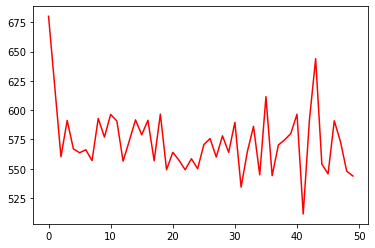

In [14]:
model = XML(input_size=X_train.shape[1], embedding_size=100, attention_layer_size=50, 
            encoder_layer_size=120, hidden_layer_size=100,output_size=Y_train.shape[1],
            margin=0.8, lamda = 10, r1 = 1e-6, use_all_singular_values = False)
model.train(X_train, Y_train, lr_ = 0.01, epochs=50, batch_size=1024) 

In [0]:
y_pred = model.predict(X_test)

# Results for DCCA loss at hidden layer
**Scores for Mediamill dataset**

In [16]:
print("P@1: ",p_k(y_pred, Y_test, 1))
print("P@3: ",p_k(y_pred, Y_test, 3))
print("P@5: ",p_k(y_pred, Y_test, 5))

P@1:  0.7543750967941769
P@3:  0.5022198131227416
P@5:  0.31277683134584155


In [17]:
print("n@1: ",n_k(y_pred, Y_test, 1))
print("n@3: ",n_k(y_pred, Y_test, 3))
print("n@5: ",n_k(y_pred, Y_test, 5))

n@1:  0.7543750967941769
n@3:  0.5895752551789218
n@5:  0.49786608519459274


# Grid Search for DCCA parameters

In [0]:
for r in [ .5*1e-7, 1e-8, .5*1e-8, 1e-9]: 
    for f in [True, False]: 
        try: 
            model = XML(input_size=X_train.shape[1], embedding_size=100, attention_layer_size=50, 
                        encoder_layer_size=120, hidden_layer_size=100,output_size=Y_train.shape[1],
                        margin=0.8, r1 = r, use_all_singular_values = f)
            model.train(X_train, Y_train, lr_ = 0.001, epochs=20, batch_size=1024) 
            print("##############################################################################") 
            print("Successfull Iteration for r = ", r, " and f = ", f)
        except : 
            print("##############################################################################") 
            print("Error Iteration Aman for r = ", r, " and f = ", f)

# Results for MSE loss at hidden layer
**Scores for Mediamill dataset**

In [0]:
print("P@1: ",p_k(y_pred, Y_test, 1))
print("P@3: ",p_k(y_pred, Y_test, 3))
print("P@5: ",p_k(y_pred, Y_test, 5))

P@1:  0.6283103608486913
P@3:  0.5773837179288812
P@5:  0.4468483816013554


In [0]:
print("n@1: ",n_k(y_pred, Y_test, 1))
print("n@3: ",n_k(y_pred, Y_test, 3))
print("n@5: ",n_k(y_pred, Y_test, 5))

n@1:  0.6283103608486913
n@3:  0.6284964713729472
n@5:  0.6027628038215489
